# Load package

In [1]:
%cd ..

E:\Coding\PlasmaChemistry


In [2]:
import os
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import Layout
from IPython.display import display
import ipywidgets as widgets

In [4]:
from plasmistry.molecule import (H2_vib_group, CO_vib_group, CO2_vib_group)
from plasmistry.molecule import (H2_vib_energy_in_eV, H2_vib_energy_in_K,
                                 CO2_vib_energy_in_eV, CO2_vib_energy_in_K,
                                 CO_vib_energy_in_eV, CO_vib_energy_in_K)
from plasmistry.io import (LT_constructor, Arr_constructor, eval_constructor,
                           Cros_Reaction_block, Coef_Reaction_block)
from plasmistry.reactions import (CrosReactions, CoefReactions)
from plasmistry.electron import EEDF
from plasmistry.electron import get_maxwell_eedf

In [5]:
import yaml
yaml.add_constructor(u"!eval", eval_constructor)
yaml.add_constructor(u"!LT", LT_constructor)
yaml.add_constructor(u"!Arr", Arr_constructor)

# Set widgets

In [6]:
_species_list = ['E', 'H2(v0-14)', 'CO2(v0-21)', 'CO(v0-10)', 'H', 'O', 'OH']
_init_yaml_file_path = './_yaml/test_0.yaml'
_vari_dict = dict(H2_vib_energy_in_eV=H2_vib_energy_in_eV,
                 CO2_vib_energy_in_eV=CO2_vib_energy_in_eV,
                 CO2_vib_energy_in_K=CO2_vib_energy_in_K)

# Load reactions


Reactions contains `electron reactions` and `relaxation reactions`



## functions
- `get_species_from_widgets`
- `load_reactions_from_widgets`
- `get_rctn_df_from_widgets`

In [16]:
rctn_considered = None
rctn_df = {'electron reactions': None, 'relaxation reactions': None}


def get_species_from_widgets(_event):
    print('set_species...', end=' ')
    species = []
    for _ in _widgets['species'].value:
        if _ == 'H2(v0-14)':
            species.append('H2')
            species.extend([f'H2(v{v})' for v in range(1, 15)])
        elif _ == 'CO2(v0-21)':
            species.append('CO2')
            species.extend([f'CO2(v{v})' for v in range(1, 22)])
        elif _ == 'CO(v0-10)':
            species.append('CO')
            species.extend([f'CO(v{v})' for v in range(11)])
        else:
            species.append(_)
    rctn_df['species'] = pd.Series(species)
    print('set done!')


# --------------------------------------------------------------------------- #


def load_reactions_from_widgets():
    with open(_widgets['path'].value, 'r') as f:
        rctn_block = yaml.load(f)
    return rctn_block[-1]['The reactions considered']


rctn_df = dict()


def get_rctn_df_from_widgets(_):
    print('loading...', end=' ')
    rctn_df['electron reactions'] = pd.DataFrame(
        columns=['formula', 'type', 'threshold_eV', 'cross_section'])
    rctn_df['relaxation reactions'] = pd.DataFrame(
        columns=['formula', 'type', 'reactant', 'product', 'kstr'])
    # ----------------------------------------------------------------------- #
    for _ in _widgets['ele'].value:
        _df = rctn_all['electron reactions'][_]
        _cros_block = Cros_Reaction_block(rctn_dict=_df, vari_dict=_vari_dict)
        rctn_df['electron reactions'] = rctn_df['electron reactions'].append(
            _cros_block.generate_crostn_dataframe())
    for _ in _widgets['rel'].value:
        _df = rctn_all['relaxation reactions'][_]
        _coef_block = Coef_Reaction_block(rctn_dict=_df, vari_dict=_vari_dict)
        rctn_df['relaxation reactions'] = rctn_df[
            'relaxation reactions'].append(
                _coef_block.generate_crostn_dataframe())
    print('Get rctn_df done!')

# Set GUI

In [17]:
_widgets = dict()
_widgets['path'] = widgets.Text(value=_init_yaml_file_path)
display(widgets.HBox([widgets.HTML('<b>Yaml File Path</b>'),
                      _widgets['path']]))
rctn_all = load_reactions_from_widgets()
# --------------------------------------------------------------------------- #
# set select multiple
for _, _option in [('ele', rctn_all['electron reactions'].keys()),
                   ('rel', rctn_all['relaxation reactions'].keys()),
                   ('species', _species_list)]:
    _widgets[_] = widgets.SelectMultiple(options=_option,
                                         layout=Layout(height='300px'))
# --------------------------------------------------------------------------- #
# set floattext
for _, _value in [('electron_density', 1.0), ('Te', 1.0), ('CO2_density', 1.0),
                  ('CO2_Tvib', 1000), ('H2_density', 1.0), ('H2_Tvib', 1000),
                  ('CO_density', 1.0), ('CO_Tvib', 1000)]:
    _widgets[_] = widgets.FloatText(value=_value, layout=Layout(width='100px'))
# --------------------------------------------------------------------------- #
# set buttons
_button = dict()
_button['load reactions'] = widgets.Button(description='Load Reactions')
_button['set init-conditions'] = widgets.Button(
    description='Set init-conditions')

# --------------------------------------------------------------------------- #
display(
    widgets.HBox([
        widgets.VBox(
            [widgets.HTML('<b>ELECTRON REACTIONS:</b>'), _widgets['ele']]),
        widgets.VBox(
            [widgets.HTML('<b>RELAXATION REACTIONS:</b>'), _widgets['rel']]),
        widgets.VBox([widgets.HTML('<b>SPECIES</b>'), _widgets['species']])
    ]))
display(
    widgets.GridBox([
        widgets.HTML('<b>electron density</b>'), _widgets['electron_density'],
        widgets.HTML('<b>Te_eV</b>'), _widgets['Te'],
        widgets.HTML('<b>CO2_density</b>'), _widgets['CO2_density'],
        widgets.HTML('<b>CO2_Tvib</b>'), _widgets['CO2_Tvib'],
        widgets.HTML('<b>H2_density</b>'), _widgets['H2_density'],
        widgets.HTML('<b>H2_Tvib'), _widgets['H2_Tvib']
    ],
                    layout=widgets.Layout(
                        grid_template_columns="repeat(4, 20%)")))
display(
    widgets.HBox([_button['load reactions'], _button['set init-conditions']]))
_button['load reactions'].on_click(get_rctn_df_from_widgets)
_button['set init-conditions'].on_click(get_species_from_widgets)

GridBox(children=(HTML(value='<b>electron density</b>'), FloatText(value=1.0, layout=Layout(width='100px')), H…

loading... Get rctn_df done!


C:\Users\PhyMan\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


set_species... set done!


In [18]:
rctn_df['electron reactions']

,formula,type,threshold_eV,cross_section
0,E + H2 => E + H2(v1),EXCITATION,0.515594,"[[0.0001, 0.00010016132706854269, 0.0001003229..."
1,E + H2 => E + H2(v2),EXCITATION,1.001103,"[[0.4856084787426168, 0.48560864006968535, 0.4..."
2,E + H2 => E + H2(v3),EXCITATION,1.456525,"[[0.9410309521450216, 0.9410311134720902, 0.94..."
3,E + H2 => E + H2(v4),EXCITATION,1.881862,"[[1.3663674202072145, 1.366367581534283, 1.366..."
4,E + H2 => E + H2(v5),EXCITATION,2.277112,"[[1.7616178829291946, 1.7616180442562632, 1.76..."
5,E + H2 => E + H2(v6),EXCITATION,2.642277,"[[2.1267823403109634, 2.1267825016380315, 2.12..."
6,E + H2 => E + H2(v7),EXCITATION,2.977355,"[[2.461860792352519, 2.461860953679587, 2.4618..."
7,E + H2 => E + H2(v8),EXCITATION,3.282348,"[[2.7668532390538636, 2.7668534003809317, 2.76..."
8,E + H2 => E + H2(v9),EXCITATION,3.557254,"[[3.0417596804149953, 3.0417598417420635, 3.04..."
9,E + H2 => E + H2(v10),EXCITATION,3.802075,"[[3.286580116435915, 3.286580277762983, 3.2865..."


In [19]:
rctn_df['relaxation reactions']

,formula,kstr,product,reactant,type
0,CO2(v1) + CO => CO2 + CO,(((0.425)*exp((-407)*Tgas**(-1/3)+(824)*Tgas**...,CO2 + CO,CO2(v1) + CO,VT
1,CO2(v2) + CO => CO2(v1) + CO,(((0.425)*exp((-407)*Tgas**(-1/3)+(824)*Tgas**...,CO2(v1) + CO,CO2(v2) + CO,VT
2,CO2(v3) + CO => CO2(v2) + CO,(((0.425)*exp((-407)*Tgas**(-1/3)+(824)*Tgas**...,CO2(v2) + CO,CO2(v3) + CO,VT
3,CO2(v4) + CO => CO2(v3) + CO,(((0.425)*exp((-407)*Tgas**(-1/3)+(824)*Tgas**...,CO2(v3) + CO,CO2(v4) + CO,VT
4,CO2(v5) + CO => CO2(v4) + CO,(((0.425)*exp((-407)*Tgas**(-1/3)+(824)*Tgas**...,CO2(v4) + CO,CO2(v5) + CO,VT
5,CO2(v6) + CO => CO2(v5) + CO,(((0.425)*exp((-407)*Tgas**(-1/3)+(824)*Tgas**...,CO2(v5) + CO,CO2(v6) + CO,VT
6,CO2(v7) + CO => CO2(v6) + CO,(((0.425)*exp((-407)*Tgas**(-1/3)+(824)*Tgas**...,CO2(v6) + CO,CO2(v7) + CO,VT
7,CO2(v8) + CO => CO2(v7) + CO,(((0.425)*exp((-407)*Tgas**(-1/3)+(824)*Tgas**...,CO2(v7) + CO,CO2(v8) + CO,VT
8,CO2(v9) + CO => CO2(v8) + CO,(((0.425)*exp((-407)*Tgas**(-1/3)+(824)*Tgas**...,CO2(v8) + CO,CO2(v9) + CO,VT
9,CO2(v10) + CO => CO2(v9) + CO,(((0.425)*exp((-407)*Tgas**(-1/3)+(824)*Tgas**...,CO2(v9) + CO,CO2(v10) + CO,VT


In [20]:
density_df = pd.Series(0, index=species)
H2 = H2_vib_group(total_density=_widgets['H2_density'].value,
                  Tvib_K=_widgets['H2_Tvib'].value)
CO2 = CO2_vib_group(total_density=_widgets['CO2_density'].value,
                    Tvib_K=_widgets['CO2_Tvib'].value)
CO = CO_vib_group(total_density=_widgets['CO_density'].value,
                  Tvib_K=_widgets['CO_Tvib'].value)

NameError: name 'species' is not defined

# Instance rctn_df

In [21]:
rctn_instances = {'electron reactions': None, 'relaxation reactions': None}


def from_rctn_df_to_cros_instance(_df):
    split_df = _df['formula'].str.split('\s*=>\s*', expand=True)
    reactant = split_df[0]
    product = split_df[1]
    return reactant, product


def from_rctn_df_to_coef_instance(_df):
    reactant = _df['reactant']
    product = _df['product']
    kstr = _df['kstr']
    return reactant, product, kstr


reactant, product = from_rctn_df_to_cros_instance(
    rctn_df['electron reactions'])
rctn_instances['electron reactions'] = CrosReactions(
    species=rctn_df['species'], reactant=reactant, product=product, k_str=None)
reactant, product, kstr = from_rctn_df_to_coef_instance(
    rctn_df['relaxation reactions'])
rctn_instances['relaxation reactions'] = CoefReactions(
    species=rctn_df['species'], reactant=reactant, product=product, k_str=kstr)
rctn_instances['relaxation reactions'].compile_k_str()
# rctn_instances['relaxation reactions'].set_rate_const(Tgas_K=1000, EN_Td=1, Te_eV=0)

In [53]:
eedf = EEDF(max_energy_eV=30, grid_number=300)
electron_energy_grid = eedf.energy_point
eedf.set_density_per_J(get_maxwell_eedf(eedf.energy_point, Te_eV=1.0))

In [54]:
rctn_instances['electron reactions'].set_rate_const_matrix(
    crostn_dataframe=rctn_df['electron reactions'],
    electron_energy_grid=electron_energy_grid)

In [69]:
y0 = rctn_instances['electron reactions'].get_initial_density(density_dict={
    'CO2': 1e25,
    'H2': 1e25,
    'E': 1e20
}, min_density=1e1)
normalized_eedf = get_maxwell_eedf(eedf.energy_point, Te_eV=1.0)


def dndt_cros(t, y):
    print(t)
    _instance = rctn_instances['electron reactions']
    _instance.set_rate_const(eedf_normalized=normalized_eedf)
    _instance.set_rate(density=y)
    return _instance.get_dn()


def dndt_coef(t, y):
    print(t)
    _instance = rctn_instances['relaxation reactions']
    _instance.set_rate_const(Tgas_K=4000, EN_Td=1.0, Te_eV=1.0)
    _instance.set_rate(density=y)
    return _instance.get_dn()

def dndt_all(t, y):
    print(t)
    return dndt_cros(t, y) + dndt_coef(t, y)

In [70]:
rctn_instances['relaxation reactions'].compile_k_str()

In [71]:
rctn_instances['relaxation reactions'].set_rate_const(Tgas_K=4000, EN_Td=1.0, Te_eV=1.0)

In [72]:
rctn_instances['relaxation reactions'].rate_const

array([1.06686780e-11, 1.20742317e-11, 1.36649606e-11, 1.54652604e-11,
       1.75027408e-11, 1.98086489e-11, 2.24183483e-11, 2.53718614e-11,
       2.87144830e-11, 3.24974753e-11, 3.67788532e-11, 4.16242747e-11,
       4.71080469e-11, 5.33142660e-11, 6.03381060e-11, 6.82872784e-11,
       7.72836833e-11, 8.74652779e-11, 9.89881918e-11, 1.12029120e-10,
       1.26788030e-10, 4.58291933e-12, 5.23343784e-12, 5.97629335e-12,
       6.82459240e-12, 7.79330193e-12, 8.89951326e-12, 1.01627437e-11,
       1.16052807e-11, 1.32525752e-11, 1.51336908e-11, 1.72818160e-11,
       1.97348501e-11, 2.25360714e-11, 2.57349012e-11, 2.93877748e-11,
       3.35591377e-11, 3.83225817e-11, 4.37621436e-11, 4.99737864e-11,
       5.70670927e-11, 6.51671964e-11])

In [79]:
rctn_instances['relaxation reactions'].set_rate(density=y0)

In [80]:
rctn_instances['relaxation reactions'].rate

array([1.06686780e-09, 1.20742317e-09, 1.36649606e-09, 1.54652604e-09,
       1.75027408e-09, 1.98086489e-09, 2.24183483e-09, 2.53718614e-09,
       2.87144830e-09, 3.24974753e-09, 3.67788532e-09, 4.16242747e-09,
       4.71080469e-09, 5.33142660e-09, 6.03381060e-09, 6.82872784e-09,
       7.72836833e-09, 8.74652779e-09, 9.89881918e-09, 1.12029120e-08,
       1.26788030e-08, 4.58291933e+14, 5.23343784e-10, 5.97629335e-10,
       6.82459240e-10, 7.79330193e-10, 8.89951326e-10, 1.01627437e-09,
       1.16052807e-09, 1.32525752e-09, 1.51336908e-09, 1.72818160e-09,
       1.97348501e-09, 2.25360714e-09, 2.57349012e-09, 2.93877748e-09,
       3.35591377e-09, 3.83225817e-09, 4.37621436e-09, 4.99737864e-09,
       5.70670927e-09, 6.51671964e-09])

In [81]:
rctn_instances['electron reactions'].set_rate(density=y0)

In [82]:
rctn_instances['electron reactions'].rate

array([1.74435285e+30, 7.32846687e+28, 6.92527744e+27, 1.21153583e+27,
       3.05912731e+26, 9.63574639e+25, 3.48027085e+25, 1.37011881e+25,
       5.69505346e+24, 2.44820452e+24, 1.07351273e+24, 4.75647006e+23,
       2.11567698e+23, 9.40421786e+22, 2.92301559e+06, 1.25454867e+05,
       1.21390900e+04, 2.17730251e+03, 5.64089525e+02, 1.82393833e+02,
       6.76454551e+01, 2.73500270e+01, 1.16763221e+01, 5.15549283e+00,
       2.32180359e+00, 1.05647515e+00, 4.82525788e-01, 4.31635002e+06,
       1.89196481e+05, 1.87387108e+04, 3.44477257e+03, 9.15407136e+02,
       3.03743518e+02, 1.15635199e+02, 4.79989209e+01, 2.10391917e+01,
       9.53755741e+00, 4.40964812e+00, 2.05964290e+00, 6.24151183e+06,
       2.79306270e+05, 2.83059040e+04, 5.33121323e+03, 1.45259255e+03,
       4.94429434e+02, 1.93140786e+02, 8.22738746e+01, 3.70102196e+01,
       1.72175538e+01, 8.16823360e+00, 9.03584932e+06, 4.12667910e+05,
       4.27754909e+04, 8.25078797e+03, 2.30407659e+03, 8.04154799e+02,
      

In [76]:
time_span = (0, 1e2)
sol = solve_ivp(dndt_all, time_span, y0, method='BDF', rtol=5e-2)

0.0
0.0
0.0
1.0510037937424009e-31
1.0510037937424009e-31
1.0510037937424009e-31
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0510037937424009e-29
1.0510037937424009e-29
1.0510037937424009e-29
1.0510037937424009e-29
1.0510037937424009e-29
1.0510037937424009e-29
2.1020075874848017e-29
2.1020075874848017e-29
2.1020075874848017e-29
2.1020075874848017e-29
2.1020075874848017e-29
2.1020075874848017

2.719431057244946e-06
2.719431057244946e-06
2.719431057244946e-06
2.719431057244946e-06
2.719431057244946e-06
3.622745393230923e-06
3.622745393230923e-06
3.622745393230923e-06
3.622745393230923e-06
3.622745393230923e-06
3.622745393230923e-06
4.5260597292169e-06
4.5260597292169e-06
4.5260597292169e-06
4.5260597292169e-06
4.5260597292169e-06
4.5260597292169e-06
5.429374065202877e-06
5.429374065202877e-06
5.429374065202877e-06
5.429374065202877e-06
5.429374065202877e-06
5.429374065202877e-06
6.332688401188855e-06
6.332688401188855e-06
6.332688401188855e-06
6.332688401188855e-06
6.332688401188855e-06
6.332688401188855e-06
8.605663613540264e-06
8.605663613540264e-06
8.605663613540264e-06
8.605663613540264e-06
8.605663613540264e-06
8.605663613540264e-06
1.0878638825891672e-05
1.0878638825891672e-05
1.0878638825891672e-05
1.0878638825891672e-05
1.0878638825891672e-05
1.0878638825891672e-05
1.3151614038243081e-05
1.3151614038243081e-05
1.3151614038243081e-05
1.3151614038243081e-05
1.3151614038

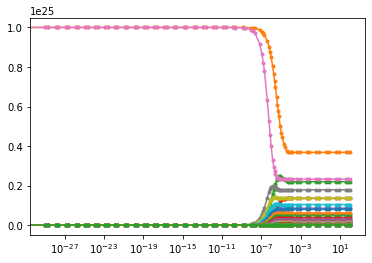

In [77]:
plt.semilogx(sol.t, sol.y.transpose(), marker='.')

In [78]:
rctn_instances['relaxation reactions'].view_density(sol.y[:,-1])

,density,ratio
E,1.000000e+20,0.0%
H2,3.682332e+24,18.4%
H2(v1),2.198277e+24,11.0%
H2(v2),1.350950e+24,6.8%
H2(v3),8.559923e+23,4.3%
H2(v4),5.592186e+23,2.8%
H2(v5),3.763004e+23,1.9%
H2(v6),2.610362e+23,1.3%
H2(v7),1.866611e+23,0.9%
H2(v8),1.375753e+23,0.7%
